In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

# Installing a package
import sys
# !{sys.executable} -m pip install [package_name]
# !{sys.executable} -m pip install mlxtend

# import mlextend.classifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Supervised_ML_UseCase_Quora Question Pair Similarity')

Mounted at /content/drive


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading features files </h2>

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised_ML_UseCase_Quora Question Pair Similarity/final_features.csv").head(100000)

In [ ]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.shape

(100000, 218)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.999983,0.857131,0.0,0.0,0.857131,0.749991,1,1,1,7.5,...,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,0.833319,0.454541,0.0,0.0,0.833319,0.454541,1,0,5,8.5,...,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,0.499992,0.428565,0.0,0.0,0.499992,0.428565,1,0,1,6.5,...,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,0.249994,0.249994,0.0,0.0,0.249994,0.249994,1,0,0,4.0,...,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,0.499992,0.272725,0.0,0.0,0.499992,0.272725,1,0,5,8.5,...,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


<h2> 4.2 Converting strings to numerics </h2>

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
# for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)
#     print(i)

data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 218 entries, cwc_min to 95_y
dtypes: float64(218)
memory usage: 166.3 MB


In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)


# split the data set into train and test
X_train,X_test, y_train, y_test = model_selection.train_test_split(data,  y_true, stratify=y_true, test_size=0.3,random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.3)


In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (49000, 218)
Number of data points in test data : (30000, 218)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)  # Output = Counter({0: 43922, 1: 26078})
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)


print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)  # Output = Counter({0: 18824, 1: 11176})
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6285306122448979 Class 1:  0.371469387755102
---------- Distribution of output variable in test data ----------
Class 0:  0.6274666666666666 Class 1:  0.3725333333333333


In [ ]:
# This function plots the confusion matrices given y_i(actual output), y_i_hat(predicted output).
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

> A random model is a model that randomly predicts the output given an input.
This is done in order get a base worst model.
Our aim is fond a model with log loss value less than the log loss value of the random(worst) model

Log loss on Test Data using Random Model 0.8813963935214069


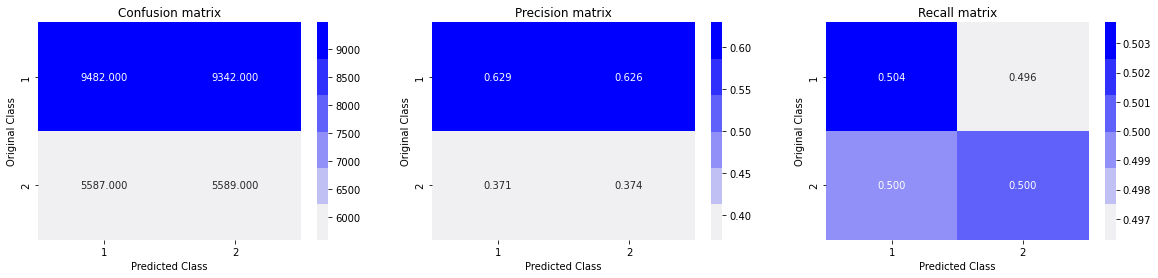

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5655494422025098
For values of alpha =  0.0001 The log loss is: 0.4730626010968873
For values of alpha =  0.001 The log loss is: 0.486748914275687
For values of alpha =  0.01 The log loss is: 0.46454281126930447
For values of alpha =  0.1 The log loss is: 0.4682185062781691
For values of alpha =  1 The log loss is: 0.4922766858341101
For values of alpha =  10 The log loss is: 0.5338765538393134


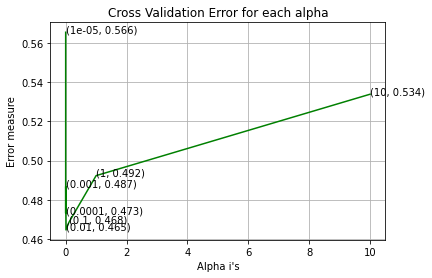

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:

    # Traing the Model at given alpha value with training dataset

    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)

    # Calibration Model so as to get probabilistic output so that Log Loss can be calculated.

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    # Predict output for validation dataset.(X_cv)
    predict_y_cv = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



### Retraining of Model with best hyperparameter values and calculating Log Loss and Confusion Matrix as KPI(key performance Indicator)

The best alpha value with least log loss:  0.01
For values of best alpha =  0.01 The train log loss is: 0.4605117747487816
For values of best alpha =  0.01 The test log loss is: 0.4630283436359216
Total number of data points : 30000


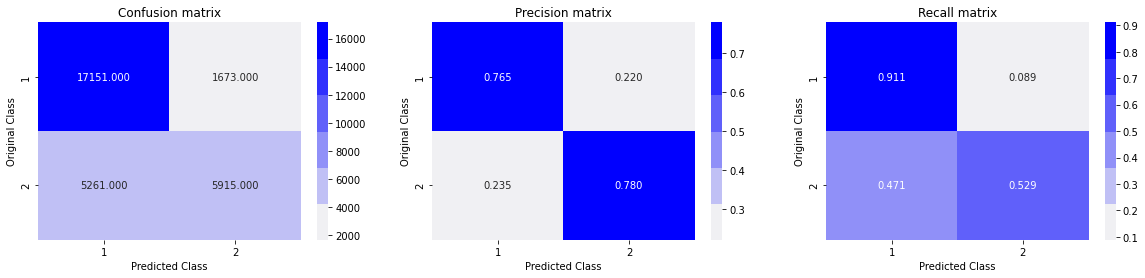

In [ ]:

#  Taking alpha with least cross validation error and retraining the model
best_alpha = np.argmin(log_error_array)
print("The best alpha value with least log loss: ",alpha[best_alpha])
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)


# Calibration Model so as to get probabilistic output so that Log Loss can be calculated.

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

# Calculating Logg loss on test dataset

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6602925151890645
For values of alpha =  0.0001 The log loss is: 0.6602925151890645
For values of alpha =  0.001 The log loss is: 0.6105415702959378
For values of alpha =  0.01 The log loss is: 0.49753753709014126
For values of alpha =  0.1 The log loss is: 0.6185918399234839
For values of alpha =  1 The log loss is: 0.6602925151890645
For values of alpha =  10 The log loss is: 0.6602925151890645


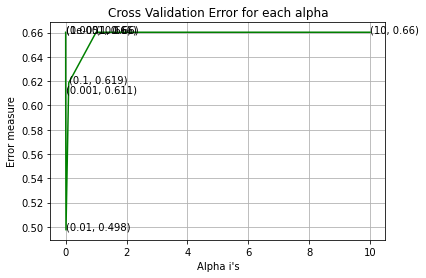

For values of best alpha =  0.01 The train log loss is: 0.4973977381563755
For values of best alpha =  0.01 The test log loss is: 0.49753753709014126
Total number of data points : 30000


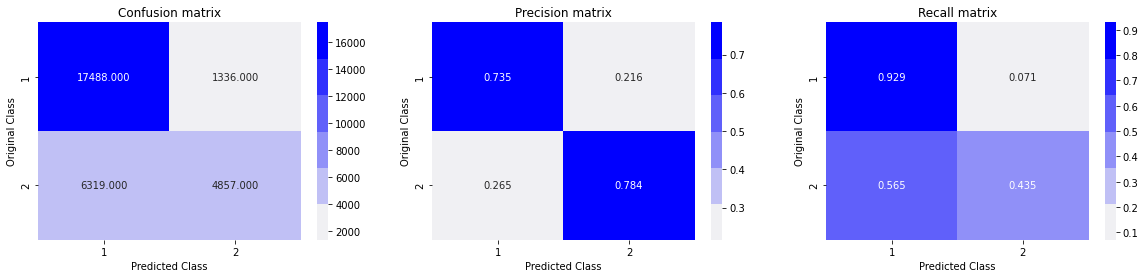

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [ ]:
# Refer from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'  # Loss function to be minimized : binary:logistic gives probabilistic output
params['eval_metric'] = 'logloss'  #The metric to be used for validation data.
# params['eta'] = 0.02
eta_rate = [10 ** x for x in range(-3, 0)]
params['max_depth'] = 4
# params['max_depth'] = [1,2,3,4,5]

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
d_cv = xgb.DMatrix(X_cv, label=y_cv)

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

loss_at_learning_rate = {}
for learning_rate in eta_rate:
  params['eta'] = learning_rate
  bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
  xgdmat = xgb.DMatrix(X_train,y_train)

  predict_y_cv = bst.predict(d_cv)
  log_loss_value = log_loss(y_cv, predict_y_cv, labels=clf.classes_, eps=1e-15)
  print("The cv log loss at learning rate : ", learning_rate, " is : ", log_loss_value)
  loss_at_learning_rate[learning_rate] = log_loss_value





[0]	train-logloss:0.692724	valid-logloss:0.692755
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.688594	valid-logloss:0.688606
[20]	train-logloss:0.684551	valid-logloss:0.684624
[30]	train-logloss:0.680645	valid-logloss:0.68061
[40]	train-logloss:0.676831	valid-logloss:0.676796
[50]	train-logloss:0.672952	valid-logloss:0.673007
[60]	train-logloss:0.669237	valid-logloss:0.669324
[70]	train-logloss:0.665545	valid-logloss:0.66567
[80]	train-logloss:0.662048	valid-logloss:0.662078
[90]	train-logloss:0.658545	valid-logloss:0.658544
[100]	train-logloss:0.655131	valid-logloss:0.655099
[110]	train-logloss:0.651593	valid-logloss:0.651671
[120]	train-logloss:0.648241	valid-logloss:0.648372
[130]	train-logloss:0.645047	valid-logloss:0.645096
[140]	train-logloss:0.641745	valid-logloss:0.641864
[150]	train-logloss:0.638631	valid-logloss:0.638704
[160]	train-logloss:0.635585	v

In [ ]:
best_learning_rate = sorted(loss_at_learning_rate.items(), key= lambda x : x[1])[0]
print("The best learning rate with least log loss is : ",best_learning_rate[0], " log loss is:  ",best_learning_rate[1])


The best learning rate with least log loss is :  0.1  log loss is:   0.35221052380773876


In [ ]:
# Retraining the model with best learning rate and calculating test log loss

params['eta'] = best_learning_rate[0]
watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
xgdmat = xgb.DMatrix(X_train,y_train)

predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.653662	test-logloss:0.65367
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.468993	test-logloss:0.469868
[20]	train-logloss:0.414441	test-logloss:0.416308
[30]	train-logloss:0.392519	test-logloss:0.395604
[40]	train-logloss:0.380713	test-logloss:0.384852
[50]	train-logloss:0.37233	test-logloss:0.377919
[60]	train-logloss:0.365692	test-logloss:0.372651
[70]	train-logloss:0.35935	test-logloss:0.368573
[80]	train-logloss:0.354797	test-logloss:0.366439
[90]	train-logloss:0.350469	test-logloss:0.364209
[100]	train-logloss:0.346776	test-logloss:0.362806
[110]	train-logloss:0.343098	test-logloss:0.361135
[120]	train-logloss:0.339686	test-logloss:0.359979
[130]	train-logloss:0.335967	test-logloss:0.358823
[140]	train-logloss:0.332822	test-logloss:0.357918
[150]	train-logloss:0.329646	test-logloss:0.357005
[160]	train-logloss:0.327211	test-logloss:0.35666

Total number of data points : 30000


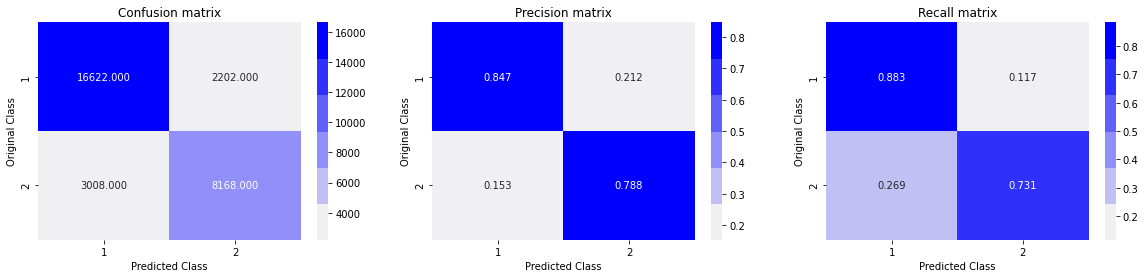

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> Conclusion </h1>

1. Random model is used as base model with log loss = 0.88
Hence our aim was to get models with log less less than 0.88

2. Models we used SGD Classifier with loss func = 'log' (= Logistic regression) 
Log loss is lesser than Random model but Precision and Recall values are quite less for class 2 (See diagonal elements in precision and recall)

3. SGD Classifier + loss func = 'hinge' (= Linear SVM) Log loss is lesser than Logistic reg model but Precision and Recall values are still quite less for class 2 (See diagonal elements in precision and recall)

4. XGBoost has lowest log loss of all and has high precision and recall for both classes. Henced XGBosst is final model that we can sue to productionize.

